# Global Parameter Optimization

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`


This notebook demonstrates how to optimize the parameters of the state-space model (implemented in **RxInfer.jl**) through an external optimization packages such as [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl/)

## Univariate case

First, lets try use the following simple model (multivariate version is presented below):
$$\begin{aligned}
    {x}_t &= {x}_{t-1} + c \\
    {y}_t &\sim \mathcal{N}\left({x}_{t}, p \right) 
\end{aligned}$$
with prior ${x}_0 \sim \mathcal{N}({m_{{x}_0}}, {v_{{x}_0}})$. Our goal is to optimize parameters $c$ and ${m_{{x}_0}}$.

In [2]:
using RxInfer, BenchmarkTools, Random, LinearAlgebra, Plots

In [3]:
@model function smoothing(n, x0, c::ConstVariable, P::ConstVariable)
    
    x_prior ~ NormalMeanVariance(mean(x0), cov(x0)) 

    x = randomvar(n)
    y = datavar(Float64, n)

    x_prev = x_prior

    for i in 1:n
        x[i] ~ x_prev + c
        y[i] ~ NormalMeanVariance(x[i], P)
        
        x_prev = x[i]
    end

    return x, y
end

In [4]:
rng = MersenneTwister(42)

P      = 1.0
n      = 250
c_real = -5.0
data   = c_real .+ collect(1:n) + rand(rng, Normal(0.0, sqrt(P)), n);

In [5]:
# c[1] is C
# c[2] is μ0
function f(c)
    x0_prior = NormalMeanVariance(c[2], 100.0)
    result = inference(
        model = smoothing(n, x0_prior, c[1], P), 
        data  = (y = data,), 
        free_energy = true
    )
    return result.free_energy[end]
end

f (generic function with 1 method)

In [6]:
using Optim

In [7]:
res = optimize(f, ones(2), GradientDescent(), Optim.Options(g_tol = 1e-3, iterations = 100, store_trace = true, show_trace = true, show_every = 10))

Iter     Function value   Gradient norm 
     0     3.683766e+02     7.580911e+02
 * time: 0.017746925354003906
    10     3.679681e+02     2.277267e+01
 * time: 6.5175299644470215


 * Status: success

 * Candidate solution
    Final objective value:     3.679676e+02

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 5.09e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.69e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.59e-08 ≰ 0.0e+00
    |g(x)|                 = 9.57e-04 ≤ 1.0e-03

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    19
    f(x) calls:    142
    ∇f(x) calls:   142


In [8]:
res.minimizer # Real values are indeed (c = 1.0 and μ0 = -5.0)

2-element Vector{Float64}:
  1.0005879774879456
 -5.043988393663863

In [9]:
println("Real value vs Optimized")
println("Real:      ", [ 1.0, c_real ])
println("Optimized: ", res.minimizer)

Real value vs Optimized
Real:      [1.0, -5.0]
Optimized: [1.0005879774879456, -5.043988393663863]


## Multivariate case

We could perform the same experiment with more complex model and multivariate observations:
$$\begin{aligned}
    \mathbf{x}_t &\sim \mathcal{N}\left(\mathbf{Ax}_{t-1}, \mathbf{Q} \right) \\
    \mathbf{y}_t &\sim \mathcal{N}\left(\mathbf{x}_{t}, \mathbf{P} \right) 
\end{aligned}$$
with prior $$\mathbf{x}_0 \sim \mathcal{N}(\mathbf{m_{{x}_0}}, \mathbf{V_{{x}_0}})$$ and transition matrix $$\mathbf{A} = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$$
Covariance matrices $\mathbf{V_{{x}_0}}$, $\mathbf{P}$ and $\mathbf{Q}$ are known.

Our goal is to optimize parameters $\mathbf{m_{{x}_0}}$ and $\theta$.

In [10]:
@model function rotate_ssm(n, θ, x0, Q::ConstVariable, P::ConstVariable)
    
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior ~ MvNormalMeanCovariance(mean(x0), cov(x0))
    
    x_prev = x_prior
    
    A = constvar([ cos(θ) -sin(θ); sin(θ) cos(θ) ])
    
    for i in 1:n
        x[i] ~ MvNormalMeanCovariance(A * x_prev, Q)
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        
        x_prev = x[i]
    end
    
end

In [11]:
# Generate data
function generate_rotate_ssm_data()
    rng = MersenneTwister(1234)

    θ = π / 8
    A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
    Q = Matrix(Diagonal(1.0 * ones(2)))
    P = Matrix(Diagonal(1.0 * ones(2)))

    n = 300

    x_prev = [ 10.0, -10.0 ]

    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        
        x[i] = rand(rng, MvNormal(A * x_prev, Q))
        y[i] = rand(rng, MvNormal(x[i], Q))
        
        x_prev = x[i]
    end

    return θ, A, Q, P, n, x, y
end

generate_rotate_ssm_data (generic function with 1 method)

In [12]:
θ, A, Q, P, n, x, y = generate_rotate_ssm_data();

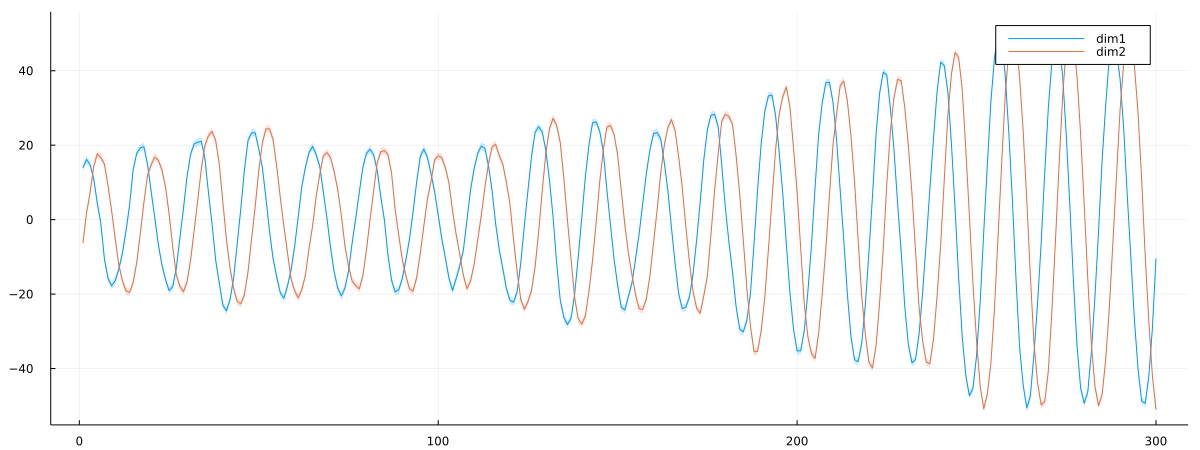

In [13]:
px = plot()

px = plot!(px, getindex.(x, 1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "dim1")
px = plot!(px, getindex.(x, 2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "dim2")

plot(px, size = (1200, 450))

In [14]:
function f(θ)
    x0 = MvNormalMeanCovariance([ θ[2], θ[3] ], Matrix(Diagonal(0.01 * ones(2))))
    result = inference(
        model = rotate_ssm(n, θ[1], x0, Q, P), 
        data  = (y = y,), 
        free_energy = true
    )
    return result.free_energy[end]
end

f (generic function with 1 method)

In [15]:
res = optimize(f, zeros(3), LBFGS(), Optim.Options(f_tol = 1e-14, g_tol = 1e-12, show_trace = true, show_every = 10))

Iter     Function value   Gradient norm 
     0     2.192003e+04     9.032537e+04
 * time: 0.00014495849609375


 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     1.161372e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.27e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-16 ≤ 1.0e-14
    |g(x)|                 = 9.39e-08 ≰ 1.0e-12

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    7
    f(x) calls:    47
    ∇f(x) calls:   47


In [16]:
println("Real value vs Optimized")
println("Real:      ", θ)
println("Optimized: ", res.minimizer[1])

@show sin(θ), sin(res.minimizer[1])
@show cos(θ), cos(res.minimizer[1])

Real value vs Optimized
Real:      0.39269908169872414
Optimized: 0.392933248139125
(sin(θ), sin(res.minimizer[1])) = (0.3826834323650898, 0.38289976345258336)
(cos(θ), cos(res.minimizer[1])) = (0.9238795325112867, 0.9237898955649795)


(0.9238795325112867, 0.9237898955649795)

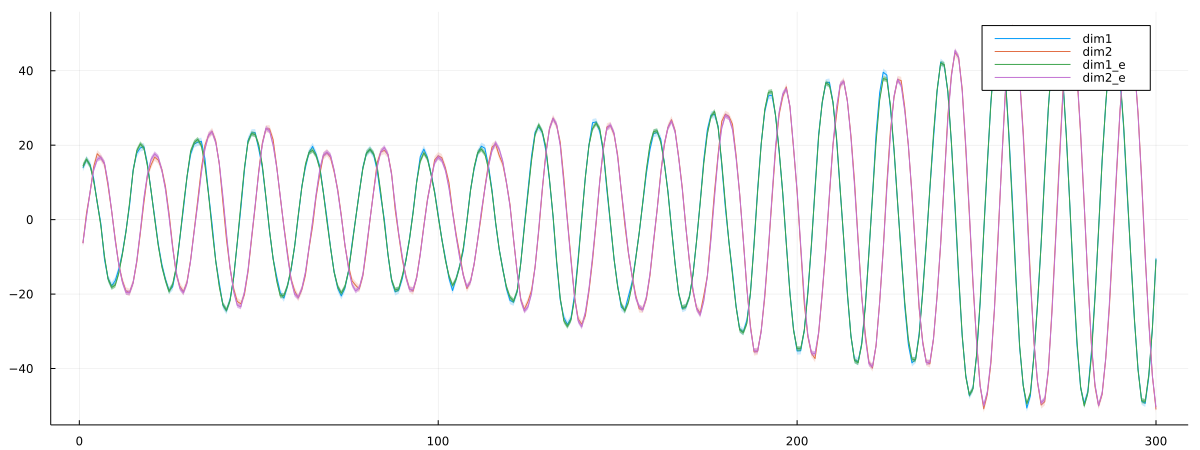

In [17]:
x0 = MvNormalMeanCovariance([ res.minimizer[2], res.minimizer[3] ], Matrix(Diagonal(100.0 * ones(2))))

result = inference(
    model = rotate_ssm(n, res.minimizer[1], x0, Q, P), 
    data  = (y = y,), 
    free_energy = true
)

xmarginals = result.posteriors[:x]

px = plot()

px = plot!(px, getindex.(x, 1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "dim1")
px = plot!(px, getindex.(x, 2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "dim2")
px = plot!(px, getindex.(mean.(xmarginals), 1), ribbon = getindex.(var.(xmarginals), 1) .|> sqrt, fillalpha = 0.5, label = "dim1_e")
px = plot!(px, getindex.(mean.(xmarginals), 2), ribbon = getindex.(var.(xmarginals), 2) .|> sqrt, fillalpha = 0.5, label = "dim2_e")

plot(px, size = (1200, 450))